In [68]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


# Load Dataset

In [69]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

lung_dataset = datasets.ImageFolder('/home/hampus/dev/bioinformatics/lung_colon_image_set/lung_image_sets',transform=transform)
#lung_dataset = datasets.ImageFolder('/home/hampus/dev/bioinformatics/lung_colon_image_set/test',transform=transform)

In [70]:
from pathlib import Path
current_file_directory = Path('cnn.ipynb').resolve().parent

print(current_file_directory)

/home/hampus/dev/bioinformatics


In [71]:
print(lung_dataset.class_to_idx)

{'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}


# Split Dataset to train and val

In [72]:

train_size = int(0.8 * len(lung_dataset)) # 80%
test_val_size = (len(lung_dataset) - train_size)//2 #val and test 10% each
print(test_val_size)

train_dataset, val_dataset, test_dataset = random_split(lung_dataset, [train_size, test_val_size, test_val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

1500


In [73]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))


images, labels = next(iter(train_loader))
print(images[0].shape)

375
47
47
torch.Size([3, 32, 32])


# Define variables

In [74]:
num_classes = 3

# Define Model

In [75]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.conv_layer3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3)


        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = F.relu(self.conv_layer_1(x))

        out = self.max_pool1(out)
        out = F.relu(self.conv_layer2(out))
        out = F.relu(self.conv_layer3(out))
        out = F.relu(self.conv_layer4(out))

        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        #out = self.dropout(out)
        out = self.fc2(out)
        return out

model = CNN(num_classes=num_classes)
print(model)

CNN(
  (conv_layer_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


# Set HyperParameters

In [76]:
num_epochs = 3

#class_weights = torch.tensor([1.2, 1.0, 1.2])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train

In [77]:
train_loss = []
val_loss = []

train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    model.train()
    total_train = 0
    correct_train = 0
    loss_train = []
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)


        total_train += len(labels)
        _, pred = torch.max(outputs.data, 1)
        correct_train += (pred == labels).sum().item()
        loss_train.append(loss.item())


        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}')
    train_loss.append(sum(loss_train)/total_train)
    train_accuracy.append(correct_train/total_train)


    ##Eval
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_loader):
            print(images)
            val_outputs = model(images)
            _, predicted = torch.max(val_outputs.data, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()
            loss_v = criterion(val_outputs, labels)
            #print(val_outputs)
        val_loss.append(loss_v.item())
        val_accuracy.append(correct/total)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {loss_v.item():.4f}')
        print("total: ", total)
        print("correct: ", correct)
        print("accuracy: ", correct/total)

Epoch [1/3], Train Loss: 0.3560
tensor([[[[0.6000, 0.4902, 0.3922,  ..., 0.6627, 0.6706, 0.6667],
          [0.5686, 0.5176, 0.4392,  ..., 0.5765, 0.5765, 0.6667],
          [0.5647, 0.5882, 0.5686,  ..., 0.6235, 0.5569, 0.6627],
          ...,
          [0.7490, 0.7490, 0.7255,  ..., 0.5529, 0.5765, 0.5137],
          [0.7451, 0.7451, 0.7490,  ..., 0.6431, 0.6392, 0.6196],
          [0.7451, 0.7451, 0.7490,  ..., 0.4510, 0.5686, 0.5608]],

         [[0.5569, 0.4314, 0.3294,  ..., 0.6706, 0.6941, 0.6627],
          [0.5020, 0.4627, 0.3804,  ..., 0.5412, 0.5608, 0.6784],
          [0.4824, 0.5294, 0.4980,  ..., 0.5451, 0.4863, 0.6824],
          ...,
          [0.8235, 0.8196, 0.7765,  ..., 0.4392, 0.4431, 0.4000],
          [0.8275, 0.8314, 0.8314,  ..., 0.5490, 0.4941, 0.4863],
          [0.8431, 0.8471, 0.8471,  ..., 0.2980, 0.4902, 0.4431]],

         [[0.8902, 0.8549, 0.8000,  ..., 0.9137, 0.9176, 0.9137],
          [0.8824, 0.8706, 0.8314,  ..., 0.8863, 0.8745, 0.9216],
          

# Plot Loss and Accuracy

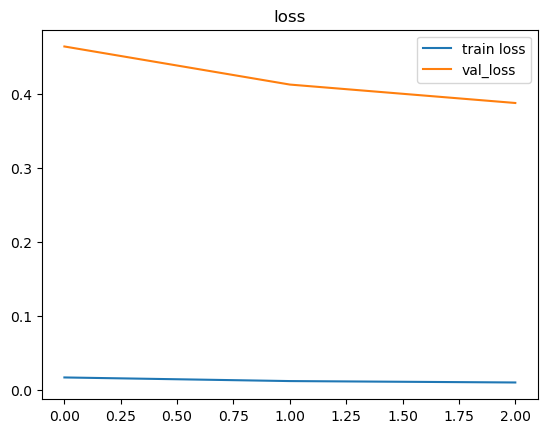

In [78]:
import matplotlib.pyplot as plt
plt.title("loss")
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

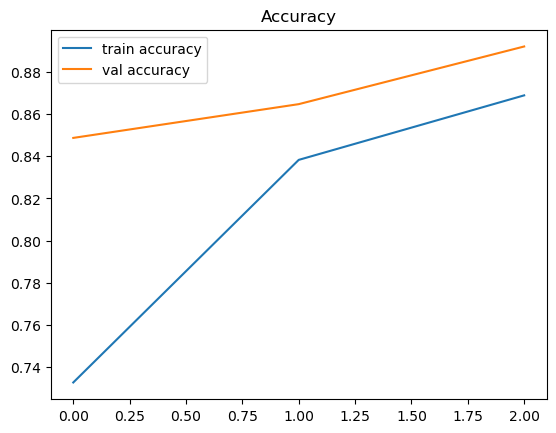

In [79]:
plt.title("Accuracy")
plt.plot(train_accuracy, label="train accuracy")
plt.plot(val_accuracy, label="val accuracy")
plt.legend()
plt.show()

# Eval

In [80]:
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels
        y_pred += predicted
        print(labels)
        print(predicted)
        total += len(labels)
        correct += (predicted == labels).sum().item()
    print("total: ", total)
    print("correct: ", correct)
    print("accuracy: ", correct/total)

tensor([2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0,
        2, 0, 0, 0, 0, 0, 0, 1])
tensor([2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 2, 2, 0,
        2, 2, 0, 0, 0, 0, 0, 1])
tensor([0, 2, 1, 2, 0, 1, 0, 0, 1, 2, 1, 2, 1, 0, 2, 1, 2, 2, 0, 2, 2, 1, 1, 0,
        1, 1, 0, 2, 0, 2, 0, 1])
tensor([0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 1, 2, 1, 0, 2, 1, 2, 2, 0, 2, 2, 1, 1, 0,
        0, 1, 0, 2, 2, 0, 0, 0])
tensor([2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 2, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0, 1,
        2, 1, 1, 1, 1, 1, 0, 2])
tensor([2, 0, 0, 2, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 0, 1,
        2, 1, 1, 1, 1, 1, 0, 2])
tensor([0, 2, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 2, 1,
        1, 1, 1, 1, 0, 0, 0, 2])
tensor([0, 2, 0, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 1,
        0, 1, 1, 1, 0, 0, 0, 2])
tensor([1, 1, 2, 0, 0, 2, 1, 1, 2, 1, 0, 0, 0, 2, 0, 0, 2, 1, 2, 2, 2, 1, 1, 1,
        2, 0, 0,

# Plot confussion matrix

Here we want to make sure that we do not get any false negatives, only false positives.

0: aca - adenocarcinoma (cancer) \
1: n - benign tissue (non-cancerous) \
2: scc - squamous cell carcinoma (cancer)

[tensor(2), tensor(0), tensor(2), tensor(0), tensor(1), tensor(0), tensor(2), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(2), tensor(0), tensor(2), tensor(0), tensor(0), tensor(2), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(2), tensor(1), tensor(2), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(2), tensor(1), tensor(2), tensor(1), tensor(0), tensor(2), tensor(1), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(2), tensor(0), tensor(2), tensor(0), tensor(1), tensor(2), tensor(0), tensor(0), tensor(2), tensor(0), tensor(1), tensor(1), tensor(1), tensor(2), tensor(0), tensor(1), tensor(1), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(1), tensor(2), tensor(0), tensor(0), tensor(1), tensor(2), tensor(1), tensor(1)

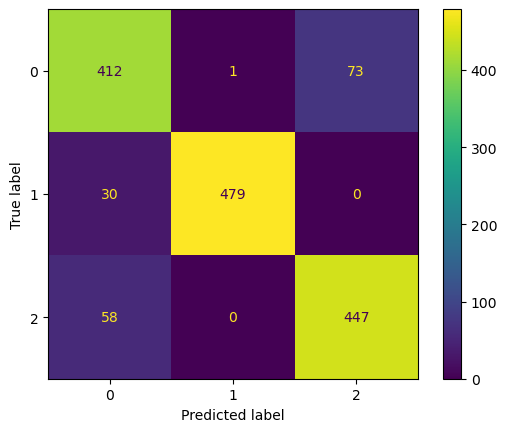

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(y_true)
print(y_pred)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

print(lung_dataset.class_to_idx)

# Save model

In [86]:
# /home/hampus/dev/bioinformatics
save = False
if save:
    PATH = "/home/hampus/dev/bioinformatics/models/first.pth"
    torch.save(model, PATH)

# Test model on Test set

In [87]:
test_true = []
test_pred = []
model.eval()
with torch.no_grad():
    test_correct = 0
    test_total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_true += labels
        test_pred += predicted
        total += len(labels)
        correct += (predicted == labels).sum().item()
    print("total: ", total)
    print("correct: ", correct)
    print("accuracy: ", correct/total)

tensor([1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0,
        0, 0, 0, 2, 2, 2, 2, 2])
tensor([1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0,
        0, 0, 2, 2, 2, 2, 2, 0])
tensor([1, 0, 1, 0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 0, 0, 2, 1, 0, 1, 1, 2, 1, 0, 0,
        2, 1, 1, 0, 1, 2, 1, 0])
tensor([1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2, 1, 2, 0,
        2, 1, 1, 2, 1, 2, 1, 0])
tensor([1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
        2, 1, 2, 0, 0, 0, 0, 1])
tensor([1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0,
        0, 1, 2, 0, 0, 0, 0, 1])
tensor([0, 0, 2, 0, 0, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 2,
        0, 1, 2, 1, 2, 0, 1, 2])
tensor([0, 0, 2, 0, 2, 0, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2,
        0, 1, 0, 1, 2, 0, 1, 2])
tensor([0, 0, 0, 2, 0, 1, 1, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 2, 0, 2, 1, 2, 2, 1,
        0, 2, 1,

[tensor(1), tensor(2), tensor(2), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(2), tensor(0), tensor(2), tensor(1), tensor(0), tensor(1), tensor(2), tensor(0), tensor(2), tensor(0), tensor(2), tensor(2), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(2), tensor(1), tensor(0), tensor(2), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(2), tensor(1), tensor(0), tensor(1), tensor(1), tensor(2), tensor(1), tensor(0), tensor(0), tensor(2), tensor(1), tensor(1), tensor(0), tensor(1), tensor(2), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(2), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(2), tensor(0), tensor(1), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(1), tensor(1), tensor(2), tensor(2), tensor(1), tensor(2)

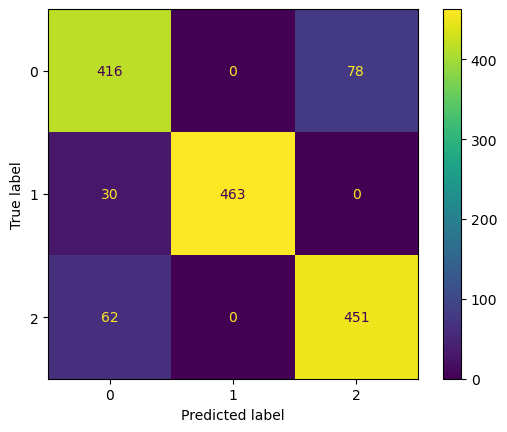

In [88]:
print(test_true)
print(test_pred)
cm = confusion_matrix(test_true, test_pred)
ConfusionMatrixDisplay(cm).plot()

print(lung_dataset.class_to_idx)